# Lines Detection

In [11]:
import numpy as np
import imageio
import math

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt
from matplotlib import cm

In [23]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)


def hough_linee(img, angle_step=1, lines_are_white=True, value_threshold=1):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    dy, dx = np.gradient(img)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    # are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(img)

    # Vote in the hough accumulator
    for x, y in zip(x_idxs, y_idxs):
        # x = x_idxs[i]
        # y = y_idxs[i]
        theta = round(np.arctan(dy[]))
        # for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            # rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            # accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
def peak_votes(accumulator, thetas, rhos):
    """ Finds the max number of votes in the hough accumulator """
    idx = np.argmax(accumulator)
    rho = rhos[idx // accumulator.shape[1]]
    theta = thetas[idx % accumulator.shape[1]]

    return idx, theta, rho


def theta2gradient(theta):
    return np.cos(theta) / np.sin(theta)


def rho2intercept(theta, rho):
    return rho / np.sin(theta)

In [39]:
image_path = 'data/binary_crosses.png'
image_path = 'data/stairs.jpg'
# image_path = 'data/tenis_court.jpg'
# image_path = 'data/tenis_court2.jpg'
# image_path = 'data/bus.png'


image = imageio.imread(image_path)
if image.ndim == 3:
    image = rgb2gray(image)

thr_val = threshold_otsu(image)
img_b = image > 230

# image = np.zeros((100, 100))
# idx = np.arange(25, 75)
# image[idx[::-1], idx] = 255
# image[idx, idx] = 255
    
# h, thetas, rhos = hough_linee(img_b, angle_step=1, lines_are_white=True, value_threshold=230)
# h, thetas, rhos = hough_linee(img_b, angle_step=1, lines_are_white=True, value_threshold=230)

# h, thetas, rhos = hough_linee(image, angle_step=1, lines_are_white=False, value_threshold=1)

# show_hough_line(image, accumulator, thetas, rhos)
peak_votes(h, thetas, rhos)

(142020, -1.5707963267948966, -595.715059588299)

In [40]:
idx = np.argmax(h)
h_max = h[idx // h.shape[1], idx % h.shape[1]]
threshold = .2 * max(h.shape)
threshold = 0.7 * h_max

cartezian_coords = list()

h_idxes = np.argwhere(h >= threshold)
polar_coords = [(rhos[r_idx], thetas[t_idx]) for r_idx, t_idx in h_idxes]
# cart_coords = [(theta2gradient(theta), rho2intercept(theta, rho)) for rho, theta in polar_coords]

In [41]:
len(polar_coords)

5

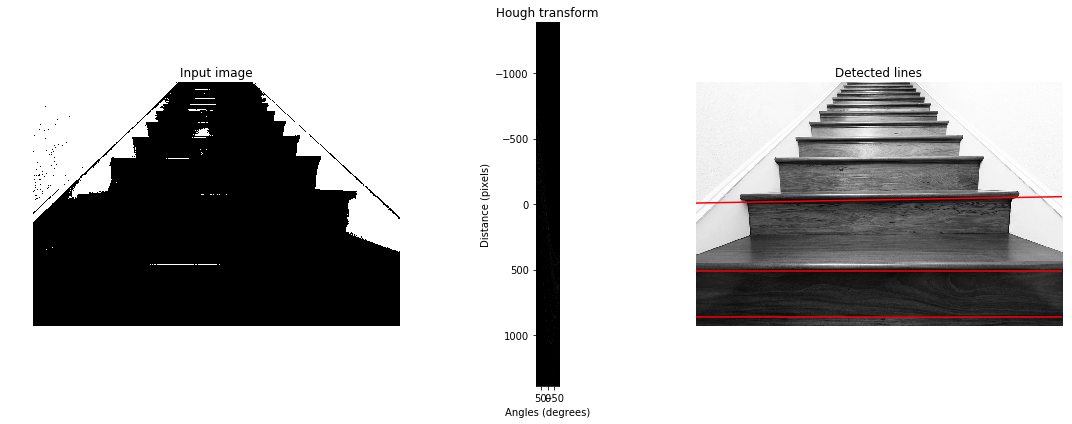

In [42]:
# Classic straight-line Hough transform
# h, theta, d = hough_line(image)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_b, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(h,  # np.log(1 + h)
             extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, thetas, rhos)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    
# for dist, angle in polar_coords:
#     y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
#     y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
#     ax[2].plot((0, image.shape[1]), (y0, y1), '-r')

# for m, b in cart_coords:
#     ax[2].plot((0, image.shape[1]), (m, b), '-r')


ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()